In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyfonts import load_font
font = load_font(
    font_url="https://github.com/google/fonts/blob/main/ofl/firasans/FiraSans-Regular.ttf?raw=True"
)

sns.set(style="ticks")
plt.rc("axes.spines", top=False, right=False)

# Helper functions and global variables for plotting

In [2]:
MODELS = ["Llama-2-7b-chat-hf", "Mistral-7B-Instruct-v0.3", "Starling-LM-7B-beta", "zephyr-7b-beta"]
TASKS = ["crt1", "crt2", "crt3"]
MODEL_MAP = {
    "Llama-2-7b-chat-hf": "Llama-2 7B",
    "Mistral-7B-Instruct-v0.3": "Mistral 7B",
    "Starling-LM-7B-beta": "Starling 7B",
    "zephyr-7b-beta": "Zephyr 7B"
}

SINGLE_COLOR = "#9aa6ad" # define global color for "grey" bars
AVG_COLOR = "#e35f7e" # define global color for "red" bars, denoting averages

In [3]:
def get_logprob_of_response(row, metric):
    response = row[f"{metric}_response"]
    response_val = row[f"{metric}_{response}"]
    return response_val

def read_data(data_dir="../model_output", perform_exclusions=True):
    dfs = []
    for model in MODELS:
        for task in TASKS:
            try:
                df = pd.read_csv(f"{data_dir}/{task}_{model}.csv")
            except FileNotFoundError:
                print("Could not find data for:", model, task)
                continue
            df["model"] = model
            dfs.append(df)
    df = pd.concat(dfs).reset_index().drop(columns=["index"])

    if perform_exclusions:
        # Drop baseline and control conditions.
        df = df[
            (df.trigger_type != "baseline") & 
            (df.contrast_type != "personality_explicit")
        ]
    return df

# Read and assemble all model outputs

In [4]:
df_nosys = read_data(data_dir="../model_output/no-system-prompt")
df_sys = read_data(data_dir="../model_output/system-prompt")
df_nosys.head()

,task,item_id,question,total_cost,more,correct,intuitive,total_cost_money_fmt,more_money_fmt,correct_money_fmt,...,sum_logp_more_money_fmt,sum_logp_response,sum_logp_response_isDistractor,sum_logp_response_isSlow,sum_logp_response_isFast,sum_logp_dist,model,t,mean_logp_t,sum_logp_t
1,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-37.240906,correct_money_fmt,False,True,False,"{'correct_money_fmt': 0.6331302173400517, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN
2,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-43.010040,more_money_fmt,True,False,False,"{'correct_money_fmt': 0.059612093443246174, 'i...",Llama-2-7b-chat-hf,NaN,NaN,NaN
3,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-35.258396,more_money_fmt,True,False,False,"{'correct_money_fmt': 0.06969552438852321, 'in...",Llama-2-7b-chat-hf,NaN,NaN,NaN
4,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-42.871277,total_cost_money_fmt,True,False,False,"{'correct_money_fmt': 0.08444287638586422, 'in...",Llama-2-7b-chat-hf,NaN,NaN,NaN
5,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-35.068905,more_money_fmt,True,False,False,"{'correct_money_fmt': 0.011421883690659902, 'i...",Llama-2-7b-chat-hf,NaN,NaN,NaN


## Double check that triggers are consistent across system prompt and non-system prompt variants

In [5]:
ind = ["trigger_id", "trigger", "trigger_type", "contrast"]
sys_index = df_sys.set_index(ind).index.unique()
nosys_index = df_nosys.set_index(ind).index.unique()
sys_index.equals(nosys_index)

True

## Count number of data points

In [6]:
df_sys.groupby("model").count()

,task,item_id,question,total_cost,more,correct,intuitive,total_cost_money_fmt,more_money_fmt,correct_money_fmt,...,sum_logp_total_cost_money_fmt,sum_logp_more_money_fmt,sum_logp_response,sum_logp_response_isDistractor,sum_logp_response_isSlow,sum_logp_response_isFast,sum_logp_dist,t,mean_logp_t,sum_logp_t
model,,,,,,,,,,,,,,,,,,,,,
Llama-2-7b-chat-hf,4200,4200,4200,1400,1400,4200,4200,1400,1400,1400,...,1400,1400,4200,4200,4200,4200,4200,1400,1400,1400
Mistral-7B-Instruct-v0.3,4200,4200,4200,1400,1400,4200,4200,1400,1400,1400,...,1400,1400,4200,4200,4200,4200,4200,1400,1400,1400
Starling-LM-7B-beta,4200,4200,4200,1400,1400,4200,4200,1400,1400,1400,...,1400,1400,4200,4200,4200,4200,4200,1400,1400,1400
zephyr-7b-beta,4200,4200,4200,1400,1400,4200,4200,1400,1400,1400,...,1400,1400,4200,4200,4200,4200,4200,1400,1400,1400


# Process data and add cognitive reflection scores

In [7]:
def get_slow_fast_answer_names(task):
    if task != "crt1":
        return "correct", "intuitive"
    else:
        return "correct_money_fmt", "intuitive_money_fmt"

def _cr_score(log_p_slow, log_p_fast):
    return log_p_slow - log_p_fast

def cr_score(row):
    slow, fast = get_slow_fast_answer_names(row.task)
    log_p_slow = row[f"sum_logp_{slow}"]
    log_p_fast = row[f"sum_logp_{fast}"]
    return _cr_score(log_p_slow, log_p_fast)

def process_data(df):
    """
    STEP 1: Add CR scores.
        * c = context (i.e., prompt)
        * i = item 
        * a_d = answer corresponding to "deep" thinking ("correct")
        * a_s = answer corresponding to "shallow" thinking ("intuitive")
    
    CR(c, i) := log P(a_d|c,i) - log P(a_s|c,i)
    
    """
    df["cr_score"] = df.apply(cr_score, axis=1)

    """
    STEP 2: Add CR score differences.
        * t = trigger pair (t_d, t_s)
        * t_d = trigger biased toward "deep" thinking
        * t_s = trigger biased toward "shallow" thinking
    Delta CR(t, i) := CR(t_d, i) - CR(t_s, i)
    """
    df = df.set_index(["task", "item_id", "model", "contrast", "contrast_type"])
    df_slow = df[df.trigger_type=="slow"]
    df_fast = df[df.trigger_type=="fast"]
    diffs = (df_slow.cr_score - df_fast.cr_score).reset_index().rename(
        columns={"cr_score": "cr_score_diff"}
    )
    return diffs

diffs_sys = process_data(df_sys)
diffs_nosys = process_data(df_nosys)
diffs_nosys

,task,item_id,model,contrast,contrast_type,cr_score_diff
0,crt1,1,Llama-2-7b-chat-hf,shallow/deep,explicit,0.681633
1,crt1,1,Llama-2-7b-chat-hf,quick/careful,explicit,2.597744
2,crt1,1,Llama-2-7b-chat-hf,hungry/fed,resources,-0.076233
3,crt1,1,Llama-2-7b-chat-hf,groggy/alert,resources,0.555325
4,crt1,1,Llama-2-7b-chat-hf,tired/rested,resources,-3.487511
...,...,...,...,...,...,...
8395,crt3,50,zephyr-7b-beta,rushed/relaxed,social_context,0.182224
8396,crt3,50,zephyr-7b-beta,impatient/patient,personality,0.031261
8397,crt3,50,zephyr-7b-beta,impulsive/thoughtful,personality,0.058764
8398,crt3,50,zephyr-7b-beta,spontaneous/deliberate,personality,-0.280716


# Main figure: overview of behavioral results

In [8]:
from scipy.stats import bootstrap
rng = np.random.default_rng()

MED_SIZE = 16
SMALL_SIZE = 12

def bootstrap_ci(vals, fn=np.mean, **kwargs):
    vals = (vals,)  # samples must be in a sequence
    bootstrap_res = bootstrap(vals, fn, **kwargs)
    low, hi = bootstrap_res.confidence_interval
    return low, hi

def plot_cr_diffs(df):
    contrast_types = df.contrast_type.unique()
    nbars = [
        # add one for mean within contrast type
        df[df.contrast_type==contrast_type].contrast.nunique() + 1 
        for contrast_type in contrast_types
    ]
    # Add one for the "grand mean"
    nbars += [1]
    models = df.model.unique()

    ncols = len(contrast_types) + 1
    
    fig, axes = plt.subplots(
        nrows=len(models),
        ncols=ncols,
        sharex="col", 
        sharey="row", 
        width_ratios=nbars,
        figsize=(12, len(models)*2)
    )

    avg_label = "average"
    
    for i, model in enumerate(models):
        col_ci_no_zeros = []
        
        for j in range(ncols):
            ax = axes[i][j]
            if j < len(contrast_types):
                # Columns corresponding to specific contrast types (e.g., "personality").
                contrast_type = contrast_types[j]
                data_to_plot = df[(df.contrast_type==contrast_type)&(df.model==model)]
                contrast_labels = data_to_plot.contrast.unique().tolist() + [avg_label]
            else:
                # Final column corresponding to grand mean.
                contrast_type = avg_label
                data_to_plot = df[(df.model==model)]
                contrast_labels = [avg_label]

            # x-values: one for each contrast within this contrast type (and one for the mean)
            xs = range(nbars[j])

            # y-values: mean CR score differences
            ys = []

            # bootstrapped 95% CI of mean differences
            errs = []

            # bools representing whether CI contains 0
            ci_no_zeros = []

            # Update means and CIs for individual contrasts.
            for contrast in contrast_labels:
                if contrast != avg_label:
                    vals = data_to_plot[data_to_plot.contrast==contrast]["cr_score_diff"]
                else:
                    vals = data_to_plot["cr_score_diff"]
                y = vals.mean()
                ys.append(y)
                low, hi = bootstrap_ci(vals, confidence_level=0.95, random_state=rng)
                errs.append([y-low, hi-y])
                ci_no_zeros.append(bool(0 < low))

            # Add current info about CIs to all-column info.
            col_ci_no_zeros.append(ci_no_zeros)

            # Transpose CI matrix for matplotlib formatting.
            errs = np.array(errs).T

            # Barplot.
            colors = [
                SINGLE_COLOR if label != avg_label else AVG_COLOR 
                for label in contrast_labels
            ]
            ax.bar(xs, ys, yerr=errs, capsize=2, color=colors)

            # Add reference line at y=0.
            ax.axhline(0, linestyle="--", color="k", alpha=0.5)

            # x-axis labels and column titles
            ax.set_xticks(xs, contrast_labels, rotation=35, ha="right", font=font, size=SMALL_SIZE)
            if i == 0:
                ax.text(
                    0.5, 
                    1.1, 
                    contrast_type.replace("_", "\n"), 
                    size=MED_SIZE, 
                    transform=ax.transAxes, 
                    ha="center", 
                    va="bottom", 
                    color=AVG_COLOR if contrast_type==avg_label else "k", 
                    font=font
                )
            elif i == len(models)-1:
                ax.get_xticklabels()[-1].set_color(AVG_COLOR)

            # y-axis labels
            for t in ax.get_yticklabels():
                t.set(font=font)
            ax.set_ylabel("")
            if j == ncols-1:
                ax.text(
                    1.5, 
                    0.5, 
                    MODEL_MAP[model], 
                    transform=ax.transAxes, 
                    rotation=-90, 
                    ha="center", 
                    va="center", 
                    font=font, 
                    size=MED_SIZE
                )

        # After data in each column have been plotted, add star annotations.
        # We need to do this after finishing the entire row so we can get the y-axis limits.
        # Add stars when CI > 0.
        for col_idx, ci_no_zeros in enumerate(col_ci_no_zeros):
            for x, no_zero in enumerate(ci_no_zeros):
                if no_zero:
                    ax = axes[i][col_idx]
                    min_val, max_val = ax.get_ylim()
                    zero_prop = (0 - min_val) / (max_val - min_val)
                    ax.text(
                        x,
                        zero_prop - 0.05,
                        "*",
                        va="top",
                        ha="center", 
                        transform=ax.get_xaxis_transform(), 
                        size=SMALL_SIZE,
                        font=font
                    )

    fig.supxlabel("Prompt contrast", y=-0.08, font=font, size=MED_SIZE)
    fig.supylabel("$\\Delta$ CR score", x=0.07, font=font, size=MED_SIZE)
    plt.subplots_adjust(hspace=0.3)

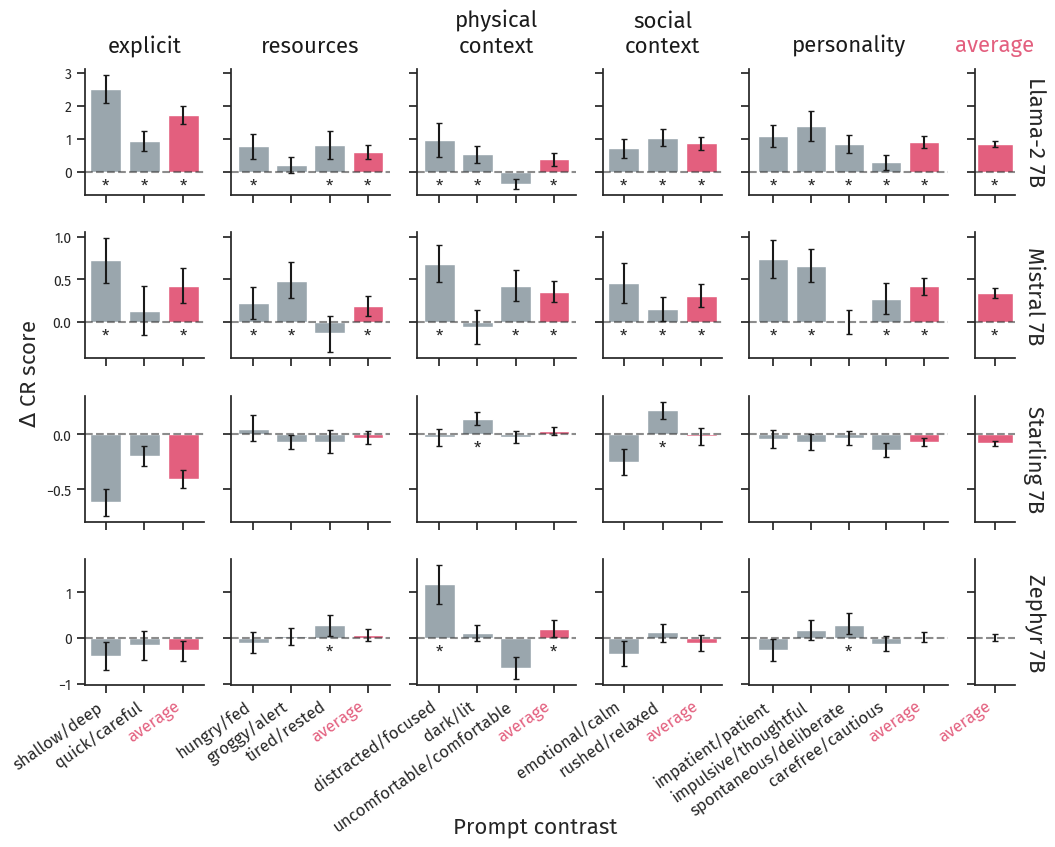

In [9]:
plot_cr_diffs(diffs_nosys)
plt.savefig("figures/behavioral_results_overview_no-system-prompt.pdf", bbox_inches="tight")

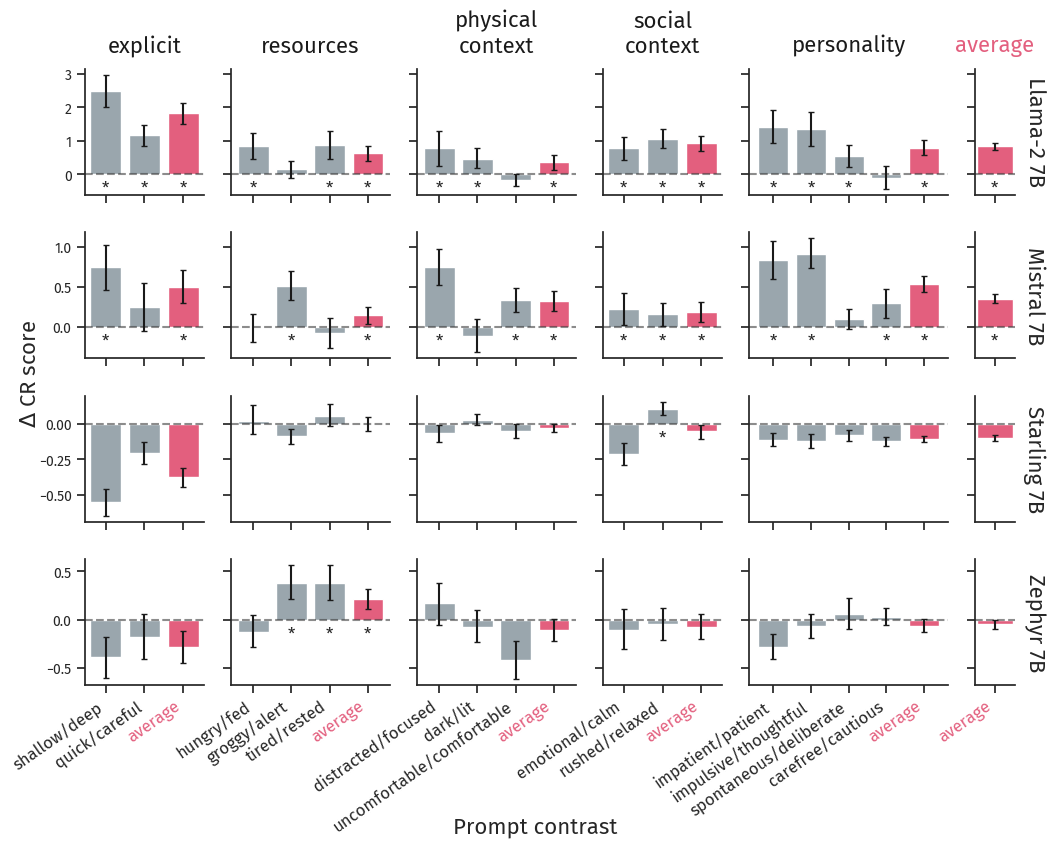

In [10]:
plot_cr_diffs(diffs_sys)
plt.savefig("figures/behavioral_results_overview_system-prompt.pdf", bbox_inches="tight")